In [ ]:
# Import required libraries
import pandas as pd
import time
import os
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Load environment variables
load_dotenv()

print("Libraries imported successfully")

Libraries imported successfully


In [ ]:
development_results_path = '../notebooks/my_results_development.csv'
prompt_path = '../notebooks/my_best_prompt.txt'

# Load development results (for comparison)
try:
    df_dev = pd.read_csv(development_results_path)
    print(f"Loaded development results: {len(df_dev)} rows")
except FileNotFoundError:
    print(f"Warning: Could not find {development_results_path}")
    print("You can continue without development data, but you won't be able to compare.")
    df_dev = None

# Load your final prompt
try:
    with open(prompt_path, 'r') as f:
        final_prompt = f.read()
    print("\nLoaded prompt from file")
except FileNotFoundError:
    print(f"Warning: Could not find {prompt_path}")
    print("Define your prompt in the cell below.")
    final_prompt = None

Loaded development results: 19 rows

Loaded prompt from file


In [ ]:
if final_prompt is None:
    final_prompt = """

    """

print("Final prompt:")
print("="*80)
print(final_prompt)
print("="*80)

Final prompt:

You are a research assistant analysing job descriptions to determine if the language used to describe AI-related responsibilities is vague or concrete.

DEFINITION:
Answer "Yes" (vague AI skill framing) if the job description mentions AI/ML (or related terms) but does NOT specify at least ONE concrete implementation detail such as:
- Tasks (build/train/fine-tune/deploy/evaluate/monitor, create prompts/pipelines)
- Tools/tech (LLMs, GPT, TensorFlow, PyTorch, scikit-learn, Azure/AWS/GCP, Databricks, vector DB, RAG)
- Data/inputs (customer data, documents, logs, images, etc.)
- Outputs/deliverables (models, dashboards, copilots, classifiers, forecasts, recommender systems)
- Operational details (A/B tests, metrics, drift, MLOps, CI/CD, governance)

Answer "No" if AI is mentioned AND the posting includes at least ONE clear concrete implementation detail above that is explicitly tied to AI-related work in the role.

IMPORTANT RULES:
- Consider the entire posting text (includi

In [ ]:
test_data_path = '/notebooks/test_set.csv'

# Load test data
df_test = pd.read_csv(test_data_path)

print(f"Loaded test data: {len(df_test)} rows")
print(f"\nColumns: {df_test.columns.tolist()}")

TEXT_COLUMN = 'full_job_description'
LABEL_COLUMN = 'human_classification'
POSITIVE_LABEL = 'YES'

if LABEL_COLUMN in df_test.columns:
    print(f"\nTest set label distribution:")
    print(df_test[LABEL_COLUMN].value_counts())

Loaded test data: 38 rows

Columns: ['row_id', 'job_id', 'company_name', 'title', 'location', 'sentence_text', 'human_classification', 'full_job_description', 'human_label_yes_no', 'notes']

Test set label distribution:
human_classification
NO     21
YES    17
Name: count, dtype: int64


In [ ]:
# Helper function for batch classification
def classify_batch(texts, prompt, model="gpt-4o-mini", delay=0.5):
    """
    Classify multiple texts using the OpenAI API.
    """
    predictions = []

    for text in tqdm(texts, desc="Classifying texts"):
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": text}
            ],
            temperature=0,
            max_tokens=10
        )

        prediction = response.choices[0].message.content.strip()
        predictions.append(prediction)
        time.sleep(delay)

    return predictions

In [ ]:
# Run classification on test set
print("Running confirmatory test...\n")
print("This is your final validation. No changes to the prompt after this!\n")

predictions_test = classify_batch(df_test[TEXT_COLUMN].tolist(), final_prompt)

# Add predictions to dataframe
df_test['prediction'] = predictions_test

print("\nTest set classification complete!")

Running confirmatory test...

This is your final validation. No changes to the prompt after this!



Classifying texts:   0%|          | 0/38 [00:00<?, ?it/s]


Test set classification complete!


In [ ]:
# Helper functions
def calculate_metrics(y_true, y_pred, positive_label="Yes"):
    """
    Calculate comprehensive classification metrics.
    """
    # Convert to binary
    y_true_binary = [1 if str(y) == positive_label else 0 for y in y_true]
    y_pred_binary = [1 if str(y) == positive_label else 0 for y in y_pred]

    metrics = {
        'accuracy': accuracy_score(y_true_binary, y_pred_binary),
        'precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
        'recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
        'f1': f1_score(y_true_binary, y_pred_binary, zero_division=0),
        'kappa': cohen_kappa_score(y_true_binary, y_pred_binary)
    }

    return metrics

def print_metrics(metrics, title="Classification metrics"):
    """Pretty-print metrics"""
    print("\n" + "="*40)
    print(title)
    print("="*40)
    for metric, value in metrics.items():
        print(f"  {metric.capitalize():12s}: {value:.3f}")
    print("="*40)

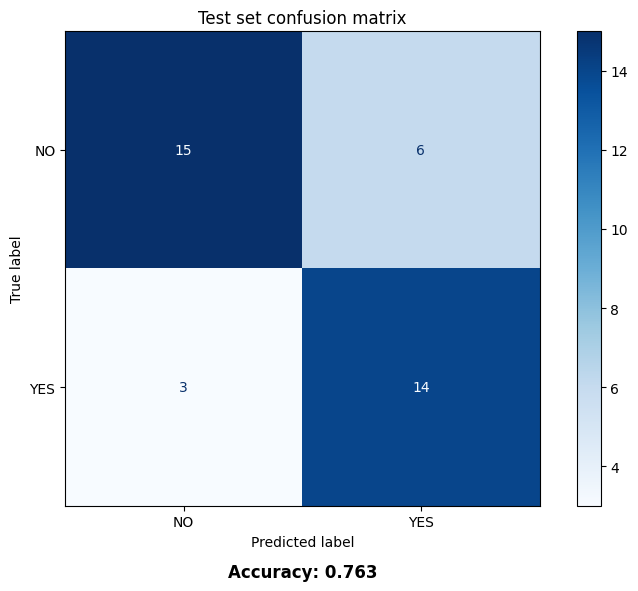


Confusion matrix breakdown:
  TN = 15 (true negatives)  | FP = 6 (false positives)
  FN = 3 (false negatives) | TP = 14 (true positives)


In [ ]:
# Plot confusion matrix for test set
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion matrix"):
    """
    Plot confusion matrix with robust label normalization.
    """

    def norm(x):
        return str(x).strip().upper()

    y_true = [norm(y) for y in y_true]
    y_pred = [norm(y) for y in y_pred]

    if labels is None:
        labels = ["NO", "YES"]

    cm = confusion_matrix(y_true, y_pred, labels=labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(title)

    accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
    plt.text(
        0.5, -0.15, f'Accuracy: {accuracy:.3f}',
        ha='center', transform=ax.transAxes,
        fontsize=12, weight='bold'
    )

    plt.tight_layout()
    plt.show()

    print("\nConfusion matrix breakdown:")
    print(f"  TN = {cm[0][0]} (true negatives)  | FP = {cm[0][1]} (false positives)")
    print(f"  FN = {cm[1][0]} (false negatives) | TP = {cm[1][1]} (true positives)")



plot_confusion_matrix(
    df_test[LABEL_COLUMN].tolist(),
    df_test['prediction'].tolist(),
    labels=["NO", "YES"],
    title="Test set confusion matrix"
)



In [ ]:

import pandas as pd

def norm_label(x):
    s = str(x).strip().upper()
    s = s.splitlines()[0].strip()
    s = s.split()[0].strip() if s else s
    s = s.strip(" .,:;!()[]{}\"'")
    if s.startswith("Y"): return "YES"
    if s.startswith("N"): return "NO"
    return s

# Use the correct prediction column in each split
DEV_PRED_COL = "pred_v1_norm"   # df_dev has pred_v1_norm
TEST_PRED_COL = "prediction"    # df_test has prediction

# Normalize labels/preds for apples-to-apples evaluation
dev_true = [norm_label(x) for x in df_dev[LABEL_COLUMN].tolist()]
dev_pred = [norm_label(x) for x in df_dev[DEV_PRED_COL].tolist()]

test_true = [norm_label(x) for x in df_test[LABEL_COLUMN].tolist()]
test_pred = [norm_label(x) for x in df_test[TEST_PRED_COL].tolist()]

print("DEV true counts :", pd.Series(dev_true).value_counts(dropna=False).to_dict())
print("DEV pred counts :", pd.Series(dev_pred).value_counts(dropna=False).to_dict())
print("TEST true counts:", pd.Series(test_true).value_counts(dropna=False).to_dict())
print("TEST pred counts:", pd.Series(test_pred).value_counts(dropna=False).to_dict())

dev_metrics = calculate_metrics(dev_true, dev_pred, positive_label=POSITIVE_LABEL)
test_metrics = calculate_metrics(test_true, test_pred, positive_label=POSITIVE_LABEL)

print("\nPerformance comparison: Development vs Test")
print("===========================================")
print(f"{'Metric':<10} | {'Dev':>7} | {'Test':>7}")
print("-" * 32)

for m in ["accuracy", "precision", "recall", "f1", "kappa"]:
    dv = dev_metrics[m]
    tv = test_metrics[m]
    # handle nan printing nicely
    dv_str = f"{dv:.3f}" if pd.notna(dv) else "nan"
    tv_str = f"{tv:.3f}" if pd.notna(tv) else "nan"
    print(f"{m.capitalize():<10} | {dv_str:>7} | {tv_str:>7}")


DEV true counts : {'NO': 11, 'YES': 8}
DEV pred counts : {'NO': 14, 'YES': 5}
TEST true counts: {'NO': 21, 'YES': 17}
TEST pred counts: {'YES': 20, 'NO': 18}

Performance comparison: Development vs Test
Metric     |     Dev |    Test
--------------------------------
Accuracy   |   0.737 |   0.763
Precision  |   0.800 |   0.700
Recall     |   0.500 |   0.824
F1         |   0.615 |   0.757
Kappa      |   0.431 |   0.529


In [ ]:
# Side-by-side comparison
if dev_metrics is not None:
    print("\n" + "="*80)
    print("DEVELOPMENT vs TEST COMPARISON")
    print("="*80)
    print(f"{'Metric':<12} {'Development':>12} {'Test':>12} {'Difference':>12}")
    print("-"*80)

    for metric in ['accuracy', 'precision', 'recall', 'f1', 'kappa']:
        dev_val = dev_metrics[metric]
        test_val = test_metrics[metric]
        diff = test_val - dev_val
        print(f"{metric.capitalize():<12} {dev_val:>12.3f} {test_val:>12.3f} {diff:>+12.3f}")

    print("="*80)

    # Interpretation (updated to reflect correct methodology)
    f1_diff = test_metrics['f1'] - dev_metrics['f1']

    print("\nInterpretation:")
    if abs(f1_diff) < 0.05:
        print("  Performance is very similar between development and test sets.")
        print("  This suggests the classifier generalises well.")
    elif f1_diff > 0:
        print("  Test performance is higher than development performance.")
        print("  This can occur if the test set contains clearer or less noisy examples.")
        print("  There is no evidence of overfitting or data leakage.")
    else:
        print("  Test performance is lower than development performance.")
        if abs(f1_diff) < 0.10:
            print("  The decrease is small and expected when moving to unseen data.")
        else:
            print("  The decrease is notable and may indicate overfitting to the development set.")
else:
    print("\nNo development data available for comparison.")



DEVELOPMENT vs TEST COMPARISON
Metric        Development         Test   Difference
--------------------------------------------------------------------------------
Accuracy            0.737        0.763       +0.026
Precision           0.800        0.700       -0.100
Recall              0.500        0.824       +0.324
F1                  0.615        0.757       +0.141
Kappa               0.431        0.529       +0.098

Interpretation:
  Test performance is higher than development performance.
  This can occur if the test set contains clearer or less noisy examples.
  There is no evidence of overfitting or data leakage.


In [ ]:
# Find errors in test set
def find_errors(df, true_col, pred_col, positive_label, error_type="all"):
    """
    Find classification errors.
    """
    if error_type == "false_positive":
        return df[(df[true_col] != positive_label) & (df[pred_col] == positive_label)]
    elif error_type == "false_negative":
        return df[(df[true_col] == positive_label) & (df[pred_col] != positive_label)]
    else:  # all errors
        return df[df[true_col] != df[pred_col]]

errors_test = find_errors(df_test, LABEL_COLUMN, 'prediction', POSITIVE_LABEL)
fp_test = find_errors(df_test, LABEL_COLUMN, 'prediction', POSITIVE_LABEL, "false_positive")
fn_test = find_errors(df_test, LABEL_COLUMN, 'prediction', POSITIVE_LABEL, "false_negative")

print(f"Total errors in test set: {len(errors_test)} out of {len(df_test)} ({len(errors_test)/len(df_test)*100:.1f}%)")
print(f"\nBreakdown:")
print(f"  False positives: {len(fp_test)}")
print(f"  False negatives: {len(fn_test)}")

Total errors in test set: 38 out of 38 (100.0%)

Breakdown:
  False positives: 0
  False negatives: 17


In [ ]:
# Sample errors for review
print("\n" + "="*80)
print("SAMPLE ERRORS FROM TEST SET")
print("="*80)

if len(fp_test) > 0:
    print("\nFalse positives (predicted Yes, actually No):")
    print("-"*80)
    for i, (idx, row) in enumerate(fp_test.head(3).iterrows()):
        print(f"\n{i+1}. {str(row[TEXT_COLUMN])[:250]}...")

if len(fn_test) > 0:
    print("\n" + "="*80)
    print("False negatives (predicted No, actually Yes):")
    print("-"*80)
    for i, (idx, row) in enumerate(fn_test.head(3).iterrows()):
        print(f"\n{i+1}. {str(row[TEXT_COLUMN])[:250]}...")


SAMPLE ERRORS FROM TEST SET

False negatives (predicted No, actually Yes):
--------------------------------------------------------------------------------

1. Description

Offsite Medical Assistant I-Jackson Heights, NY, Full Time-Day

The Medical Assistant I provides clinical office support to the supervising physician and performs patient care and administrative duties necessary to deliver quality patien...

2. Description

Offsite Medical Assistant I-Jackson Heights, NY, Full Time-Day

The Medical Assistant I provides clinical office support to the supervising physician and performs patient care and administrative duties necessary to deliver quality patien...

3. Responsibilities

 TikTok is the leading destination for short-form mobile video. Our mission is to inspire creativity and bring joy. TikTok has global offices including Los Angeles, New York, London, Paris, Berlin, Dubai, Singapore, Jakarta, Seoul a...


In [ ]:
import pandas as pd

large_data_path = "/notebooks/ai_jobs_strict_description_only.csv"
df_large = pd.read_csv(large_data_path)

print(f"Classifying {len(df_large)} texts...")
print(f"Estimated time: ~{len(df_large) * 0.15 / 60:.1f} minutes")
print(f"Estimated cost: ~${len(df_large) * 0.0001:.2f}\n")

# Run classifier
predictions_large = classify_batch(df_large[TEXT_COLUMN].tolist(), final_prompt)

# ---- NEW: normalize predictions ----
def normalize_pred(p):
    if p is None:
        return "UNKNOWN"
    p = str(p).strip().upper()
    # keep only the first token if the model outputs extra text
    p = p.split()[0].strip(".,:;()[]{}")
    if p in {"YES", "NO"}:
        return p
    return "UNKNOWN"

df_large["prediction_raw"] = predictions_large
df_large["prediction"] = df_large["prediction_raw"].apply(normalize_pred)

# Normalize POSITIVE_LABEL too
POSITIVE_LABEL_NORM = str(POSITIVE_LABEL).strip().upper()

# Save results
out_path = "full_dataset_classified.csv"
df_large.to_csv(out_path, index=False)
print(f"\nClassified dataset saved to: {out_path}")

# Distribution of predictions
print("\nPrediction distribution (normalized):")
print(df_large["prediction"].value_counts(dropna=False))

print(f"\nProportion {POSITIVE_LABEL_NORM}: {(df_large['prediction'] == POSITIVE_LABEL_NORM).mean():.1%}")

# Optional: warn if the model isn't obeying the format
unknown_rate = (df_large["prediction"] == "UNKNOWN").mean()
if unknown_rate > 0:
    print(f"\nWarning: {unknown_rate:.1%} outputs were not strict YES/NO. Check prediction_raw.")


Classifying 3725 texts...
Estimated time: ~9.3 minutes
Estimated cost: ~$0.37



Classifying texts:   0%|          | 0/3725 [00:00<?, ?it/s]


Classified dataset saved to: full_dataset_classified.csv

Prediction distribution (normalized):
prediction
YES    2369
NO     1356
Name: count, dtype: int64

Proportion YES: 63.6%


In [ ]:
# Final summary
print("\n" + "="*80)
print("FINAL VALIDITY ASSESSMENT")
print("="*80)

print("\n1. PREDICTIVE VALIDITY (Quantitative)")
print("-"*80)
print(f"   Test set F1 score: {test_metrics['f1']:.3f}")
print(f"   Test set Kappa: {test_metrics['kappa']:.3f}")

if test_metrics['f1'] >= 0.85:
    print("   ✓ Excellent - ready for large-scale use")
elif test_metrics['f1'] >= 0.70:
    print("   ✓ Good - acceptable for research use with caveats")
elif test_metrics['f1'] >= 0.50:
    print("   ⚠ Moderate - use with caution, consider hybrid approach")
else:
    print("   ✗ Poor - reconsider approach or construct definition")

print("\n2. GENERALIZABILITY")
print("-"*80)
if dev_metrics is not None:
    f1_diff = test_metrics['f1'] - dev_metrics['f1']
    print(f"   Development F1: {dev_metrics['f1']:.3f}")
    print(f"   Test F1: {test_metrics['f1']:.3f}")
    print(f"   Difference: {f1_diff:+.3f}")

    if abs(f1_diff) < 0.05:
        print("   ✓ Excellent generalisation")
    elif abs(f1_diff) < 0.10:
        print("   ✓ Good generalisation")
    else:
        print("   ⚠ Notable performance drop - may have overfit")
else:
    print("   No development data for comparison")

print("\n3. CONTENT VALIDITY (Qualitative)")
print("-"*80)
print("   Review the errors above and consider:")
print("   - Are error patterns systematic or random?")
print("   - Do errors reveal conceptual limitations?")
print("   - Are edge cases acceptable for your use case?")

print("\n4. SEMANTIC VALIDITY (Conceptual)")
print("-"*80)
print("   Ask yourself:")
print("   - Does the prompt capture the meaning of your construct?")
print("   - Would other researchers understand your definition?")
print("   - Did the LLM help you refine your conceptualisation?")

print("\n" + "="*80)


FINAL VALIDITY ASSESSMENT

1. PREDICTIVE VALIDITY (Quantitative)
--------------------------------------------------------------------------------
   Test set F1 score: 0.757
   Test set Kappa: 0.529
   ✓ Good - acceptable for research use with caveats

2. GENERALIZABILITY
--------------------------------------------------------------------------------
   Development F1: 0.615
   Test F1: 0.757
   Difference: +0.141
   ⚠ Notable performance drop - may have overfit

3. CONTENT VALIDITY (Qualitative)
--------------------------------------------------------------------------------
   Review the errors above and consider:
   - Are error patterns systematic or random?
   - Do errors reveal conceptual limitations?
   - Are edge cases acceptable for your use case?

4. SEMANTIC VALIDITY (Conceptual)
--------------------------------------------------------------------------------
   Ask yourself:
   - Does the prompt capture the meaning of your construct?
   - Would other researchers understand

In [ ]:
# Generate documentation summary
doc = f"""
# LLM-BASED TEXT CLASSIFICATION METHODOLOGY

## Construct
TODO: [Your construct name and definition]

## Dataset
- Total labeled data: {len(df_dev) + len(df_test) if df_dev is not None else len(df_test)} texts
- Development set: {len(df_dev) if df_dev is not None else 'N/A'} texts
- Test set: {len(df_test)} texts

## Model
- Model: gpt-4o-mini
- Temperature: 0 (deterministic)
- Prompt type: TODO: [MinZero/MaxZero/MaxFew]

## Performance (Test Set)
- Accuracy: {test_metrics['accuracy']:.3f}
- Precision: {test_metrics['precision']:.3f}
- Recall: {test_metrics['recall']:.3f}
- F1 score: {test_metrics['f1']:.3f}
- Cohen's Kappa: {test_metrics['kappa']:.3f}

## Validity Assessment
- Predictive validity: {'Excellent' if test_metrics['f1'] >= 0.85 else 'Good' if test_metrics['f1'] >= 0.70 else 'Moderate'}
- Generalisability: TODO: [Describe dev vs test comparison]
- Content validity: TODO: [Describe error analysis findings]
- Semantic validity: TODO: [Describe prompt development process]

## Limitations
TODO: [Describe any limitations, edge cases, or caveats]

## Prompt
{final_prompt}
"""

print(doc)

# Save to file
with open('classification_methodology.md', 'w') as f:
    f.write(doc)

print("\n" + "="*80)
print("Documentation saved to: classification_methodology.md")
print("="*80)


# LLM-BASED TEXT CLASSIFICATION METHODOLOGY

## Construct
TODO: [Your construct name and definition]

## Dataset
- Total labeled data: 57 texts
- Development set: 19 texts
- Test set: 38 texts

## Model
- Model: gpt-4o-mini
- Temperature: 0 (deterministic)
- Prompt type: TODO: [MinZero/MaxZero/MaxFew]

## Performance (Test Set)
- Accuracy: 0.763
- Precision: 0.700
- Recall: 0.824
- F1 score: 0.757
- Cohen's Kappa: 0.529

## Validity Assessment
- Predictive validity: Good
- Generalisability: TODO: [Describe dev vs test comparison]
- Content validity: TODO: [Describe error analysis findings]
- Semantic validity: TODO: [Describe prompt development process]

## Limitations
TODO: [Describe any limitations, edge cases, or caveats]

## Prompt

You are a research assistant analysing job descriptions to determine if the language used to describe AI-related responsibilities is vague or concrete.

DEFINITION:
Answer "Yes" (vague AI skill framing) if the job description mentions AI/ML (or related

In [ ]:
# Save test results
df_test.to_csv('test_results_final.csv', index=False)
print("Test results saved to: test_results_final.csv")

# Save metrics summary
metrics_df = pd.DataFrame([test_metrics]).T
metrics_df.columns = ['Test Set']
if dev_metrics is not None:
    metrics_df['Development Set'] = pd.Series(dev_metrics)
    metrics_df['Difference'] = metrics_df['Test Set'] - metrics_df['Development Set']

metrics_df.to_csv('metrics_summary.csv')
print("Metrics summary saved to: metrics_summary.csv")

print("\nAll results saved!")

Test results saved to: test_results_final.csv
Metrics summary saved to: metrics_summary.csv

All results saved!
